# 0. 预处理

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from pathlib import Path
from typing import Optional, List
from torchvision.transforms.v2.functional import to_pil_image
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from torchvision.utils import flow_to_image
import pickle
from torchcodec.decoders import VideoDecoder
import cv2
import ot
import tempfile
import open_clip
import imageio
from IPython.display import Video, display

In [2]:
def plot(imgs):
    fig, axes = plt.subplots(nrows=len(imgs), ncols=len(imgs[0]), figsize=(len(imgs[0])*3, len(imgs)*2))
    axes = np.array(axes).reshape(len(imgs), len(imgs[0]))
    for i in range(len(imgs)):
        for j in range(len(imgs[i])):
            axes[i][j].imshow(imgs[i][j])
            axes[i][j].axis('off')
    plt.tight_layout(pad=0.5)
    plt.show()

In [3]:
class VideoClip:
    # 包含 首位帧显著目标检测结果 平均语义 首位光流
    def __init__(self, start_frame: int, end_frame: int):
        self.start_frame = start_frame
        self.end_frame = end_frame
        self.start_saliency = None
        self.end_saliency = None
        self.embeddings = None
        self.start_flow = None
        self.end_flow = None

In [51]:
video_dir_path = Path(".") / "BilibiliVideos" / "BV1Vb41177ud"
video_path = video_dir_path / "video.mp4"
pkl_path = video_dir_path / "clips.pkl"
decoder = VideoDecoder(video_path)

In [5]:
def get_imgs(clip: VideoClip, frame_type: int):
    if frame_type == 0:
        frame = clip.start_frame
        saliency = clip.start_saliency
        flow = clip.start_flow
    elif frame_type == 1:
        frame = clip.end_frame
        saliency = clip.end_saliency
        flow = clip.end_flow
    else:
        raise ValueError()
        
    sim = Image.fromarray(saliency*255).convert('RGB')
    sim = sim.resize((decoder.metadata.width, decoder.metadata.height),resample=Image.BILINEAR)
    fim = Image.fromarray(flow_to_image(torch.tensor(flow)).permute(1, 2, 0).numpy()).convert('RGB')
    fim = fim.resize((decoder.metadata.width, decoder.metadata.height),resample=Image.BILINEAR)
    return [to_pil_image(decoder[frame]), sim, fim]

In [6]:
def show_clips(clips: List[VideoClip], fps = None):
    if not fps:
        fps = decoder.metadata.average_fps
    all_frames = []
    for clip in clips:
        all_frames.extend(decoder[clip.start_frame : clip.end_frame + 1])

    frames_tensor = torch.stack(all_frames)
    
    frames_np = frames_tensor.permute(0, 2, 3, 1).cpu().numpy()

    imageio.mimwrite("temp_video.mp4", frames_np, fps=fps, quality=8, macro_block_size=None)
    
    # 展示视频
    display(Video("temp_video.mp4", embed=True, width=300))

In [7]:
def cosine_similarity(vec1: np.array, vec2: np.array):
    """计算两个向量的余弦相似度"""
    vec1 = vec1.flatten()
    vec2 = vec2.flatten()
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    # 避免除以零
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0.0

    return dot_product / (norm_vec1 * norm_vec2)

# 1. 获取数据

## 1.1 直接读取

In [52]:
with open(pkl_path, 'rb') as f:
    clips = pickle.load(f)

## 1.2 计算

In [8]:
from scenedetect import detect, AdaptiveDetector

In [9]:
scene_list = detect(str(video_path), AdaptiveDetector(min_scene_len = 5))

In [10]:
clips = [VideoClip(scene[0].get_frames(), scene[1].get_frames() - 1) for scene in scene_list]

### 1.2.1 计算显著性

In [11]:
import importlib
U2NET = importlib.import_module("U-2-Net.model").U2NET
net = U2NET(3,1)
net.load_state_dict(torch.load("U-2-Net/saved_models/u2net/u2net.pth"))
net.cuda()

U2NET(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(32, 32, k

In [12]:
# normalize the predicted SOD probability map
def normPRED(d):
    ma = np.max(d)
    mi = np.min(d)

    dn = (d-mi)/(ma-mi)

    return dn

In [13]:
u2nettransform = transforms.Compose([
    transforms.Resize(
        size=(320, 320),
        interpolation=InterpolationMode.BILINEAR,
        antialias=True
    ),
    transforms.Lambda(lambda x: x / 255.0),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class U2Net_Dataset(Dataset):
    def __init__(self, decoder: VideoDecoder, clips: list[VideoClip]):
        self.idx = []
        self.type = [] # 0: start 1: end
        self.decoder = decoder
        self.clips = clips
        for i in range(len(clips)):
            self.idx.append(i)
            self.type.append(0)
            self.idx.append(i)
            self.type.append(1)

    def __len__(self):
        return len(self.idx)

    def __getitem__(self, idx):
        clip_id = self.idx[idx]
        clip_type = self.type[idx]
        if clip_type == 0:
            clip_frame = self.decoder[self.clips[clip_id].start_frame]
        else:
            clip_frame = self.decoder[self.clips[clip_id].end_frame]
        clip_frame = u2nettransform(clip_frame)
        return clip_id, clip_type, clip_frame

In [14]:
data = U2Net_Dataset(decoder, clips)
dataloader = DataLoader(data, batch_size=32, shuffle=False, num_workers=1)

In [15]:
for idx, types, frames in tqdm(dataloader):
    with torch.no_grad():
        pred = net(frames.cuda())[0][:,0,:,:].cpu().detach().numpy()
        for i in range(len(idx)):
            clip_idx = idx[i].item()
            frame_type = types[i].item()
            if frame_type == 0:
                clips[clip_idx].start_saliency = normPRED(pred[i])
            else:
                clips[clip_idx].end_saliency = normPRED(pred[i])


  0%|          | 0/13 [00:00<?, ?it/s]/home/keli/VideoEdit/U-2-Net/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


### 1.2.2 计算语义

In [78]:
for clip in clips:
    clip.embeddings = None

In [16]:
num_frames = 8

In [62]:
model_name = 'ViT-B-32'

model, _, _ = open_clip.create_model_and_transforms(
    model_name, 
    pretrained="open_clip_model.safetensors", 
    device="cuda"
)
tokenizer = open_clip.get_tokenizer(model_name)

In [63]:
# CLIP 标准的均值和方差 (绝大多数 OpenCLIP 模型都用这组参数)
OPENAI_DATASET_MEAN = (0.48145466, 0.4578275, 0.40821073)
OPENAI_DATASET_STD = (0.26862954, 0.26130258, 0.27577711)

# 定义一个专门处理 Tensor 的 transform
# 输入假设: (C, H, W) 或 (B, C, H, W)，值在 0-1 之间
cliptransform = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC), # 调整大小
    transforms.CenterCrop(224), # 裁剪中心 (如果是长方形图片)
    transforms.Lambda(lambda x: x / 255.0),
    transforms.Normalize(mean=OPENAI_DATASET_MEAN, std=OPENAI_DATASET_STD) # 归一化
])

In [64]:
class CLIP_Dataset(Dataset):
    def __init__(self, decoder: VideoDecoder, clips: list[VideoClip]):
        self.idx = []
        self.frame_idx = []
        self.decoder = decoder
        for i in range(len(clips)):
            frameidxs = np.linspace(clips[i].start_frame, clips[i].end_frame, num_frames, dtype=int)
            for frameid in frameidxs:
                self.idx.append(i)
                self.frame_idx.append(frameid)

    def __len__(self):
        return len(self.idx)

    def __getitem__(self, idx):
        clip_id = self.idx[idx]
        clip_frame = cliptransform(self.decoder[idx])
        return clip_id, clip_frame

In [65]:
data = CLIP_Dataset(decoder, clips)
dataloader = DataLoader(data, batch_size=32, shuffle=False, num_workers=1)

In [79]:
for idxs, frames in tqdm(dataloader):
    with torch.no_grad():
        res = model.encode_image(frames.cuda()).cpu().detach().numpy()
        for i in range(len(idxs)):
            clip_idx = idxs[i].item()
            if clips[clip_idx].embeddings is None:
                clips[clip_idx].embeddings = res[i] / num_frames
            else:
                clips[clip_idx].embeddings += res[i] / num_frames

100%|██████████| 49/49 [00:07<00:00,  6.13it/s]


### 1.2.3. 计算光流

In [1]:
from torchvision.models.optical_flow import Raft_Large_Weights

weights = Raft_Large_Weights.DEFAULT
rafttransforms = weights.transforms()

from torchvision.models.optical_flow import raft_large

model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).cuda()
model = model.eval()

In [ ]:
resizetransforms = transforms.Resize(
    size=(320, 320),
    interpolation=InterpolationMode.BILINEAR,
    antialias=True
)

class RAFT_Dataset(Dataset):
    def __init__(self, decoder: VideoDecoder, clips: list[VideoClip]):
        self.idx = []
        self.type = []
        self.decoder = decoder
        self.clips = clips
        for i in range(len(clips)):
            self.idx.append(i)
            self.type.append(0)
            self.idx.append(i)
            self.type.append(1)
    
    def __len__(self):
        return len(self.idx)

    def __getitem__(self, idx):
        clip_id = self.idx[idx]
        clip_type = self.type[idx]
        if clip_type == 0:
            clip_img1 = self.decoder[self.clips[clip_id].start_frame]
            clip_img2 = self.decoder[self.clips[clip_id].start_frame + 1]
        else:
            clip_img1 = self.decoder[self.clips[clip_id].end_frame - 1]
            clip_img2 = self.decoder[self.clips[clip_id].end_frame]
        clip_img1 = resizetransforms(clip_img1)
        clip_img2 = resizetransforms(clip_img2)
        return clip_id, clip_type, clip_img1, clip_img2


NameError: name 'transforms' is not defined

In [25]:
data = RAFT_Dataset(decoder, clips)
dataloader = DataLoader(data, batch_size=16, shuffle=False, num_workers=1)

In [26]:
for idxs, types, img1_batch, img2_batch in tqdm(dataloader):
    with torch.no_grad():
        img1_batch, img2_batch = rafttransforms(img1_batch, img2_batch)
        flows = model(img1_batch.cuda(), img2_batch.cuda())[-1].cpu().detach().numpy()
        for i in range(len(idxs)):
            clip_idx = idxs[i].item()
            clip_type = types[i].item()
            if clip_type == 0:
                clips[clip_idx].start_flow = flows[i]
            elif clip_type == 1:
                clips[clip_idx].end_flow = flows[i]

100%|██████████| 25/25 [00:06<00:00,  4.08it/s]


### 1.2.4. 保存数据

In [16]:
with open(pkl_path, "wb") as f:
    pickle.dump(clips, f)

# 2. 分析

## 2.1 构图相似

In [10]:
pot_size = 32
y, x = np.meshgrid(np.arange(pot_size), np.arange(pot_size))
coords = np.stack((x.flatten(), y.flatten()), axis=1)
M = ot.dist(coords, coords, metric='euclidean')

def get_pot_emd(map1, map2, reg=0.1):
    m1 = cv2.resize(map1, (pot_size, pot_size), interpolation=cv2.INTER_AREA)
    m2 = cv2.resize(map2, (pot_size, pot_size), interpolation=cv2.INTER_AREA)
    
    a = m1.flatten() / (np.sum(m1) + 1e-10)
    b = m2.flatten() / (np.sum(m2) + 1e-10)
    
    dist = ot.sinkhorn2(a, b, M, reg=reg)
    
    # 归一化
    max_dist = np.sqrt(pot_size**2 + pot_size**2)
    return dist / max_dist

In [11]:
def get_fast_emd(map1, map2):
    """
    极速投影 Wasserstein 距离 (利用 CDF 性质)
    时间复杂度: O(H + W) -> 几乎瞬间完成
    """
    # 1. 归一化 (必须保证 sum=1)
    # 加上 eps 防止除以 0
    m1 = map1 / (np.sum(map1) + 1e-10)
    m2 = map2 / (np.sum(map2) + 1e-10)

    # 2. 投影到 X 轴和 Y 轴 (降维)
    # shape: (H, W) -> (W,) 和 (H,)
    x_pdf1 = np.sum(m1, axis=0)
    x_pdf2 = np.sum(m2, axis=0)
    
    y_pdf1 = np.sum(m1, axis=1)
    y_pdf2 = np.sum(m2, axis=1)

    # 3. 计算累积分布函数 (CDF)
    # 这一步是数学魔法：1D EMD = |CDF1 - CDF2| 的积分
    x_cdf1 = np.cumsum(x_pdf1)
    x_cdf2 = np.cumsum(x_pdf2)
    
    y_cdf1 = np.cumsum(y_pdf1)
    y_cdf2 = np.cumsum(y_pdf2)

    # 4. 计算 CDF 之间的差异 (L1 范数)
    dist_x = np.sum(np.abs(x_cdf1 - x_cdf2))
    dist_y = np.sum(np.abs(y_cdf1 - y_cdf2))

    # 5. 归一化
    # 原始距离是像素单位，除以图像尺寸归一化
    h, w = map1.shape
    norm_dist = np.sqrt((dist_x / w)**2 + (dist_y / h)**2)
    
    return norm_dist

In [12]:
def get_saliency_score(clip1: VideoClip, clip2: VideoClip, mode = 0):
    if mode == 0:
        return 1 - get_fast_emd(clip1.end_saliency, clip2.start_saliency)
    else:
        return 1 - get_pot_emd(clip1.end_saliency, clip2.start_saliency)

In [13]:
similarities = [(i, get_saliency_score(clips[i], clips[i + 1])) for i in tqdm(range(len(clips) - 1))]
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
print(sum([x[1] for x in similarities]) / len(similarities))

100%|██████████| 561/561 [00:00<00:00, 15165.61it/s]

0.77706337


In [14]:
len(clips)

562

0.9093516


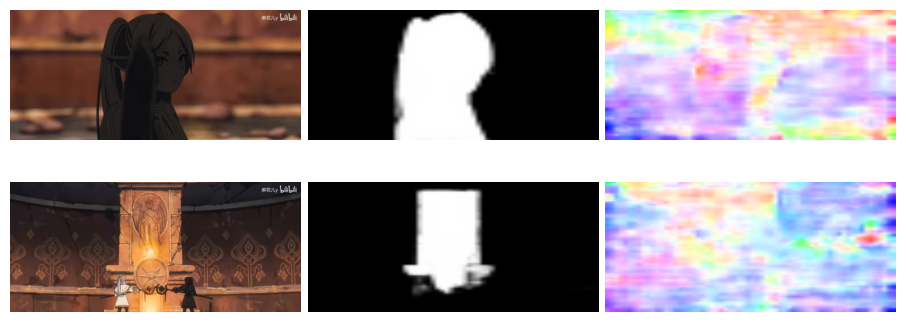

In [18]:
ith = 90
print(similarities[ith][1])
plot([get_imgs(clips[similarities[ith][0]], 1), get_imgs(clips[similarities[ith][0] + 1], 0)])

## 2.2 语义相似

In [34]:
def get_embeddings_score(clip1: VideoClip, clip2: VideoClip):
    return cosine_similarity(clip1.embeddings, clip2.embeddings)

In [80]:
similarities = [(i, get_embeddings_score(clips[i], clips[i + 1])) for i in range(len(clips) - 1)]
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
print(sum([x[1] for x in similarities]) / len(similarities))

0.9417071


0.9671405


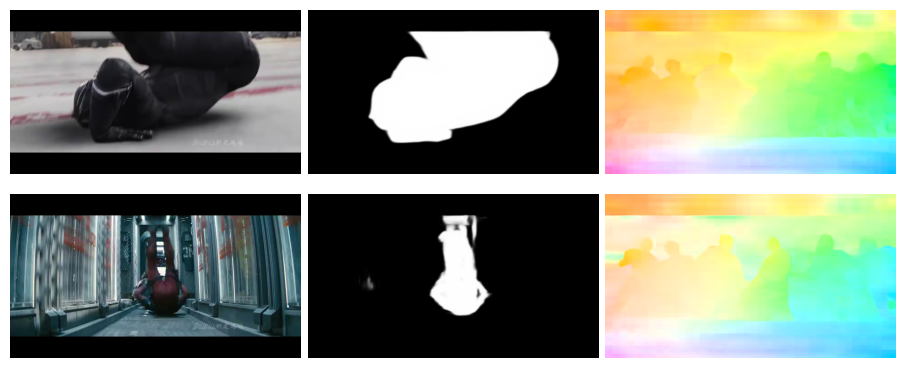

In [88]:
ith = 100
print(similarities[ith][1])
plot([get_imgs(clips[similarities[ith][0]], 1), get_imgs(clips[similarities[ith][0] + 1], 0)])

## 2.3 运动相似

In [53]:
def get_flow_score(clip1: VideoClip, clip2: VideoClip, alpha = 0.7, show_detail = False):
    def get_vec(f, s):
        w = s / (np.sum(s) + 1e-8)
        return np.sum(f.astype(np.float32) * w[np.newaxis, :, :], axis=(1, 2))
    v1 = get_vec(clip1.end_flow, clip1.end_saliency)
    v2 = get_vec(clip2.start_flow, clip2.start_saliency)
    # --- 2. 计算方向分 (Direction) ---
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)

    # 余弦相似度 [-1, 1]
    cosine = np.dot(v1, v2) / (norm1 * norm2)
    # 关键：Clip 负值。如果方向相反，得分为 0，而不是负分
    dir_score = max(0.0, cosine)

    if norm1 < 2 or norm2 < 2:
        dir_score = 0.6

    # --- 3. 计算速度分 (Speed) ---
    # 相对速度差异，范围 0~1
    speed_diff = abs(norm1 - norm2) / max(norm1, norm2)
    spd_score = 1.0 - speed_diff

    if show_detail:
        print(f"norm {norm1: .2f} {norm2: .2f}")
        print(f"dir_score {dir_score: .2f}")
        print(f"spd_score {spd_score: .2f}")

    # --- 4. 融合 (Weighted Sum) ---
    # 权重推荐：方向 70%，速度 30%
    final_score = 0.7 * dir_score + 0.3 * spd_score
    
    return float(final_score)

In [54]:
similarities = [(i, get_flow_score(clips[i], clips[i + 1])) for i in range(len(clips) - 1)]
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
print(sum([x[1] for x in similarities]) / len(similarities))

0.47617354716893306


norm  11.21  9.01
dir_score  1.00
spd_score  0.80
0.9383307099342346


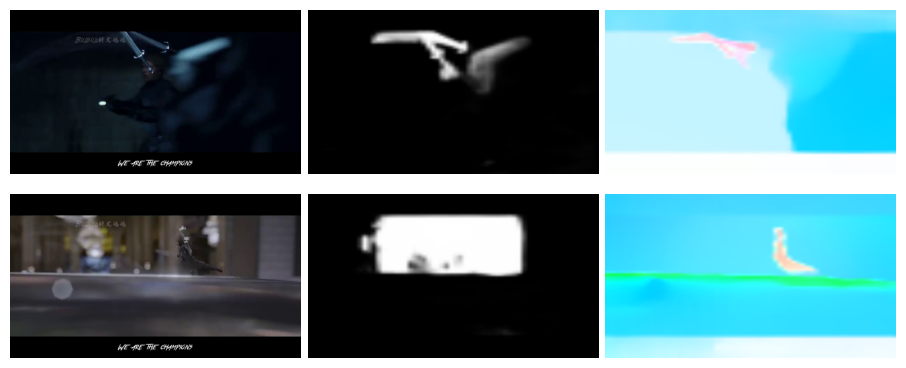

In [ ]:
ith = 1
(idx, sim) = similarities[ith]
print(get_flow_score(clips[idx], clips[idx + 1], show_detail=True))
plot([get_imgs(clips[idx], 1), get_imgs(clips[idx + 1], 0)])

In [22]:
show_clips([clips[idx], clips[idx + 1]], fps=30)

0.7090851068496704


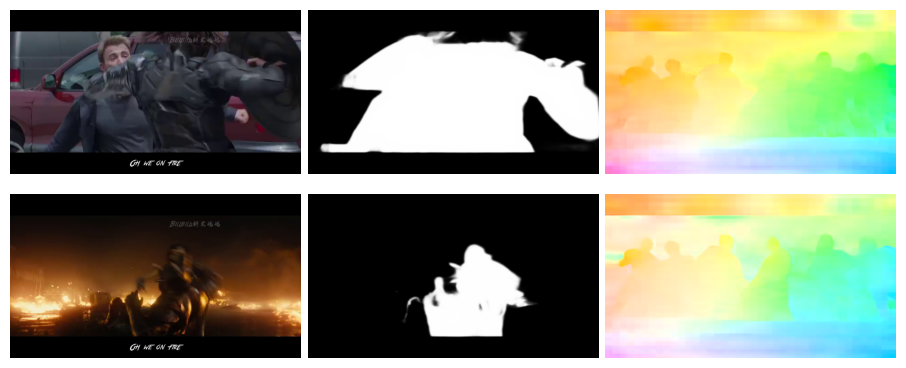

In [46]:
ith = 6
(idx, sim) = similarities[ith]
print(sim)
plot([get_imgs(clips[idx], 1), get_imgs(clips[idx + 1], 0)])

In [122]:
show_clips([clips[idx], clips[idx + 1]], fps=15)